# Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

In [1]:
# imports
import numpy as np
import cv2
import glob
import pickle
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

In [2]:
# general params

# calibration grid size
nx = 9
ny = 6
# calibration pickle filename
cal_fname = 'calibration.pkl'
# output image folder
output_folder = 'output_images/'

## Camera calibration

In [3]:
# get all camera calibration images
fnames = glob.glob('camera_cal/calibration*.jpg')

objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane

# initialize object points (these stay const)
objp = np.zeros((nx*ny,3), np.float32)
objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1, 2)

# enumerate over each image and add image points to array
for idx, fname in enumerate(fnames):
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # find corners
    ret, corners = cv2.findChessboardCorners(gray, (nx,ny), None)
    
    if ret:
        objpoints.append(objp)
        imgpoints.append(corners)
        # img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
        # plt.imshow(img)
    else:
        print('No corners found for {}'.format(fname))

No corners found for camera_cal/calibration5.jpg
No corners found for camera_cal/calibration4.jpg
No corners found for camera_cal/calibration1.jpg


In [4]:
# calibrate
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1],None,None)
# save calibration
with open(cal_fname, 'wb') as cal_file:
    pickle.dump((mtx, dist), cal_file)

In [5]:
# retrive calibration and undistort
camera_matrix, distortion_coff = None, None
with open(cal_fname, 'rb') as cal_file:
    camera_matrix, distortion_coff = pickle.load(cal_file)
print('Camera_matrix:')
print(camera_matrix)
print('Distortion coefficients:')
print(distortion_coff)

Camera_matrix:
[[1.15396093e+03 0.00000000e+00 6.69705357e+02]
 [0.00000000e+00 1.14802496e+03 3.85656234e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]
Distortion coefficients:
[[-2.41017956e-01 -5.30721173e-02 -1.15810355e-03 -1.28318856e-04
   2.67125290e-02]]


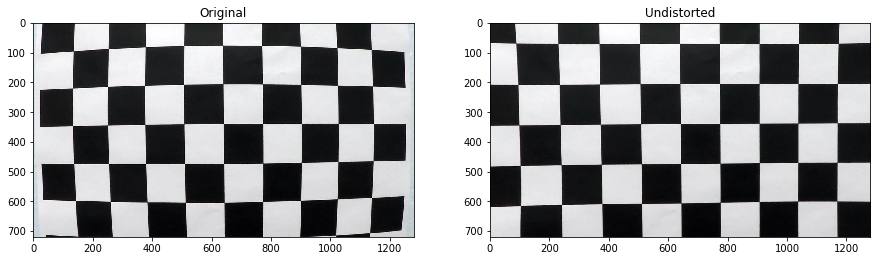

In [6]:
# undistort sample image
# note this image was not used for calibration because all corners could not be found
img = cv2.imread('camera_cal/calibration1.jpg')
# undistort image
dst = cv2.undistort(img, camera_matrix, distortion_coff, None, camera_matrix)
plt.figure(figsize=(15,10))
plt.subplot(121)
plt.title('Original')
plt.imshow(img)
plt.subplot(122)
plt.title('Undistorted')
plt.imshow(dst)
plt.savefig(os.path.join(output_folder, 'calibration.jpg'), bbox_inches='tight')
plt.show()

## Lane Detection Pipeline

In [7]:
# sample images
images = glob.glob('test_images/*.jpg')

In [8]:
def display_channels(img, labels, save_path=''):
    assert len(labels)==3 and img.shape[2]==3
    plt.figure(figsize=(20,10))
    plt.subplot(131)
    plt.title(labels[0])
    plt.imshow(img[:,:,0], cmap='gray')
    plt.subplot(132)
    plt.title(labels[1])
    plt.imshow(img[:,:,1], cmap='gray')
    plt.subplot(133)
    plt.title(labels[2])
    plt.imshow(img[:,:,2], cmap='gray')
    if save_path:
        plt.savefig(save_path)
    plt.show()

### Color space

RGB


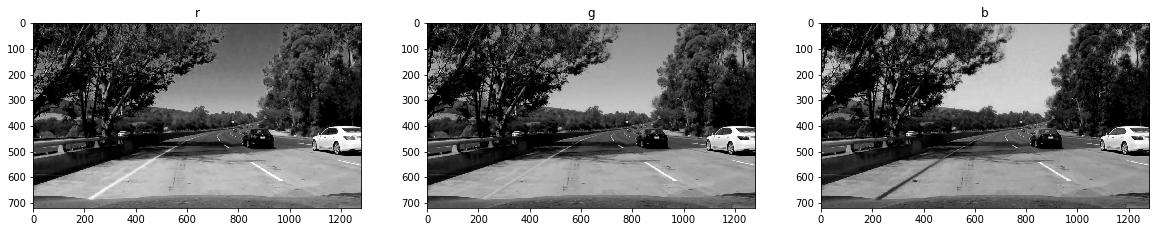

HSV


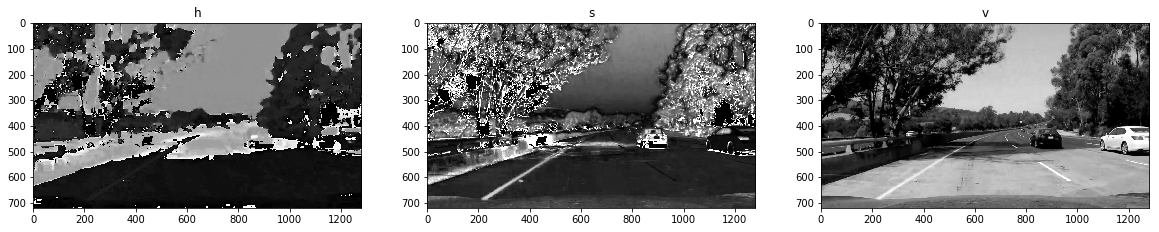

HLS


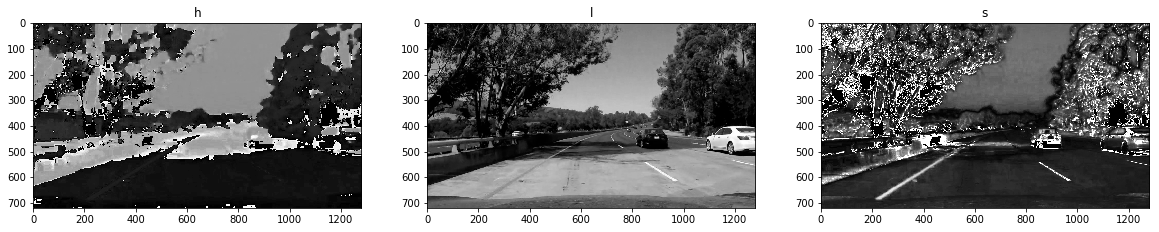

LAB


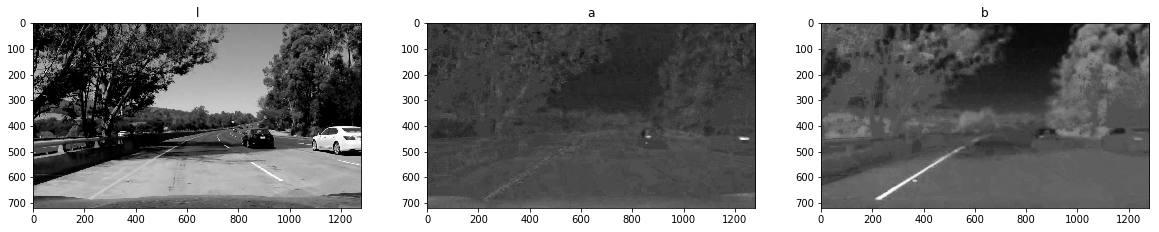

In [9]:
# color spaces test
img = mpimg.imread(images[1])
print("RGB")
display_channels(img, ['r','g','b'], os.path.join(output_folder, 'rgb'))
print("HSV")
display_channels(cv2.cvtColor(img, cv2.COLOR_RGB2HSV), ['h', 's', 'v'], os.path.join(output_folder, 'hsv'))
print("HLS")
display_channels(cv2.cvtColor(img, cv2.COLOR_RGB2HLS), ['h', 'l', 's'], os.path.join(output_folder, 'hls'))
print("LAB")
display_channels(cv2.cvtColor(img, cv2.COLOR_RGB2Lab), ['l', 'a', 'b'], os.path.join(output_folder, 'lab'))

HLS gives the best results for yellow and white lines. The L channel can be ignored to make us more light invariant.

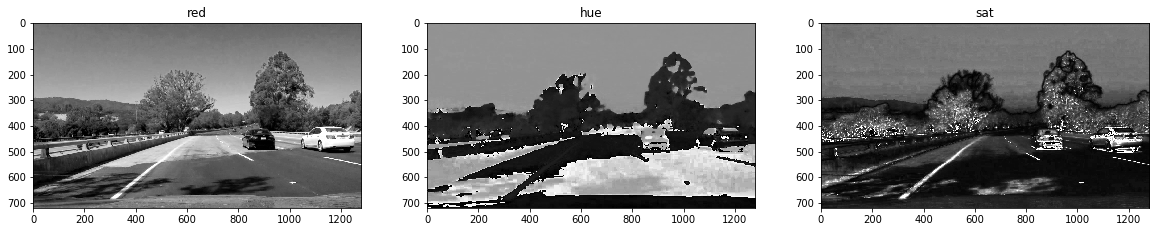

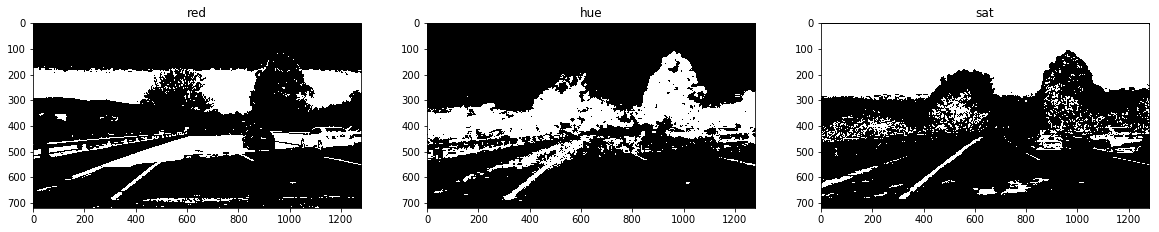

In [10]:
# thresholding
img = mpimg.imread(images[2])
hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
r_channel = img[:,:,0]
h_channel = hls[:,:,0]
s_channel = hls[:,:,2]
display_channels(np.dstack((r_channel,h_channel,s_channel)), ['red', 'hue', 'sat'], os.path.join(output_folder, 'red_hue_sat.jpg'))

def threshold(img, thresh):
    assert len(img.shape) == 2
    mask = np.zeros_like(img)
    mask[(img >= thresh[0]) & (img <= thresh[1])] = 1
    return mask

r_thresh = (150,255)
red_mask = threshold(r_channel, r_thresh)
h_thresh = (15, 100)
hue_mask = threshold(h_channel, h_thresh)
s_thresh = (100, 255)
sat_mask = threshold(s_channel, s_thresh)

display_channels(np.dstack((red_mask,hue_mask,sat_mask)), ['red', 'hue', 'sat'], os.path.join(output_folder, 'red_hue_sat_threshold.jpg'))

Red channel gives us some imformation on lane lines. The lines are thicker but it has more noise.
Hue has too much noise to compute anything.
Sat gives us both lane lines without too much noise

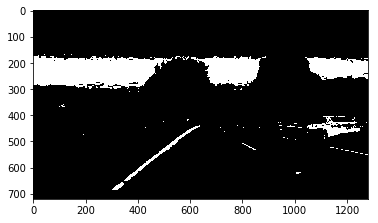

In [11]:
mask = np.zeros_like(sat_mask)
mask[((sat_mask == 1) & (red_mask == 1))] = 1
plt.imshow(mask, cmap='gray')
plt.savefig(os.path.join(output_folder, 'combined_mask.jpg'))

### Gradient threshold

In [12]:
# helper functions for gradient

# takes derivate in one axis and thresholds on it
def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0,255)):
    # single channel
    assert len(img.shape) == 2
    # take derivative
    derivative = None
    if orient == 'x':
        derivative = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    elif orient == 'y':
        derivative = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # take abs value
    abs_derivative = np.absolute(derivative)
    # scale up to 8-bit
    scaled_derivative = np.int8(255*abs_derivative/np.max(abs_derivative))
    # create mask with threshold
    mask = np.zeros_like(scaled_derivative)
    mask[(scaled_derivative >= thresh[0]) & (scaled_derivative <= thresh[1])] = 1
    return mask

# takes derivate in x and y and thresholds on combined magnitude
def mag_thresh(img, sobel_kernel=3, thresh=(0,255)):
    # single channel
    assert len(img.shape) == 2
    # take derivative
    derivative_x = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    derivative_y = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # take magnitude value
    mag_derivative = np.sqrt(np.square(derivative_x) + np.square(derivative_y))
    # scale up to 8-bit
    scaled_derivative = np.int8(255*mag_derivative/np.max(mag_derivative))
    # create mask with threshold
    mask = np.zeros_like(scaled_derivative)
    mask[(scaled_derivative >= thresh[0]) & (scaled_derivative <= thresh[1])] = 1
    return mask

# takes derivative in x and y and thresholds on direction of gradient
def dir_thresh(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    # single channel
    assert len(img.shape) == 2
    # take derivative
    derivative_x = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    derivative_y = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # take abs of x and y
    abs_x = np.absolute(derivative_x)
    abs_y = np.absolute(derivative_y)
    # find direction
    direction = np.arctan2(abs_y, abs_x)
    # create mask with threshold
    mask = np.zeros_like(direction)
    mask[(direction >= thresh[0]) & (direction <= thresh[1])] = 1
    return mask

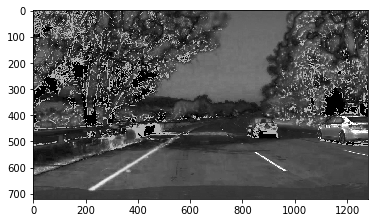

In [13]:
img = mpimg.imread(images[1])
hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
s_channel = hls[:,:,2]
r_channel = img[:,:,0]
r_s_channel = cv2.addWeighted(s_channel, 0.7, r_channel, 0.3, 0)
plt.imshow(r_s_channel, cmap='gray')

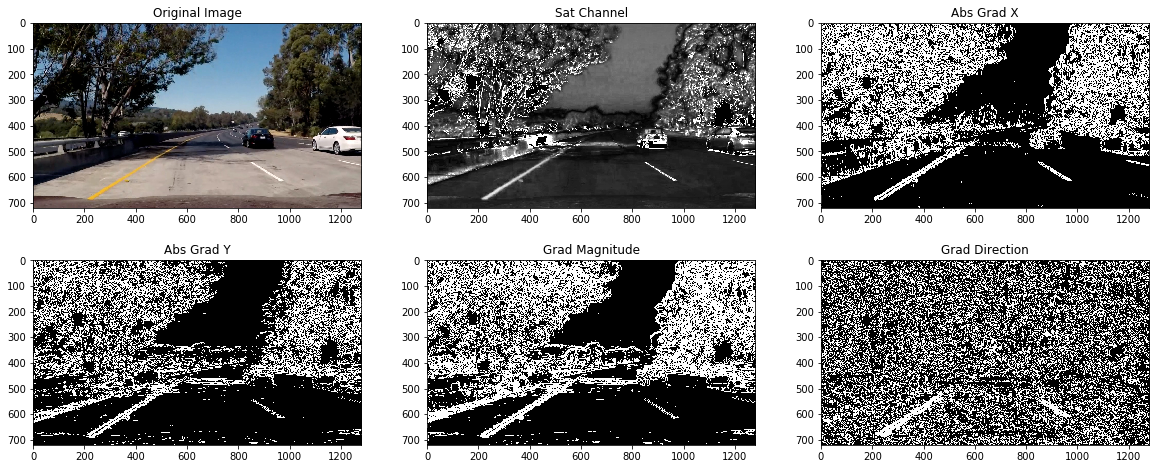

In [14]:
# gradients test
img = mpimg.imread(images[1])
hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
s_channel = hls[:,:,2]
grad_x = abs_sobel_thresh(s_channel, 'x', sobel_kernel=9, thresh=(10,100))
grad_y = abs_sobel_thresh(s_channel, 'y', sobel_kernel=3, thresh=(10,100))
grad_mag = mag_thresh(s_channel, sobel_kernel=5, thresh=(10,100))
grad_dir = dir_thresh(s_channel, sobel_kernel=19, thresh=(0.7, 1.3))

plt.figure(figsize=(20,8))
plt.subplot(231)
plt.title('Original Image')
plt.imshow(img)
plt.subplot(232)
plt.title('Sat Channel')
plt.imshow(s_channel, cmap='gray')
plt.subplot(233)
plt.title('Abs Grad X')
plt.imshow(grad_x, cmap='gray')
plt.subplot(234)
plt.title('Abs Grad Y')
plt.imshow(grad_y, cmap='gray')
plt.subplot(235)
plt.title('Grad Magnitude')
plt.imshow(grad_mag, cmap='gray')
plt.subplot(236)
plt.title('Grad Direction')
plt.imshow(grad_dir, cmap='gray')
# plt.savefig(os.path.join(output_folder, 'gradient_masks.jpg'))
plt.show()

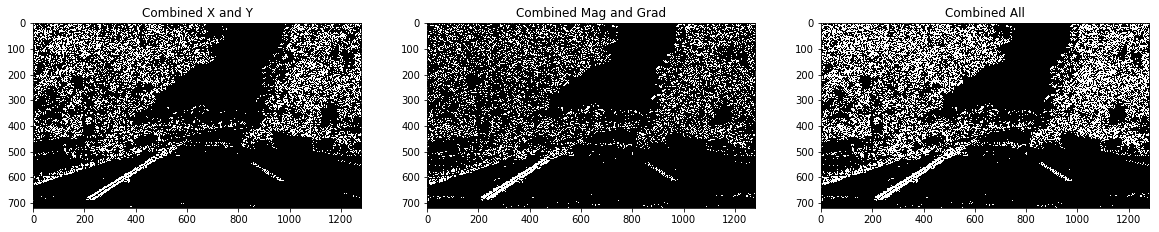

In [15]:
combined_xy = np.zeros_like(grad_dir)
combined_xy[(grad_x == 1) & (grad_y == 1)] = 1

combined_mag_dir = np.zeros_like(grad_dir)
combined_mag_dir[(grad_mag == 1) & (grad_dir == 1)] = 1

combined = np.zeros_like(combined_xy)
combined[(combined_xy == 1) | (combined_mag_dir == 1)] = 1

plt.figure(figsize=(20,10))
plt.subplot(131)
plt.title('Combined X and Y')
plt.imshow(combined_xy, cmap='gray')
plt.subplot(132)
plt.title('Combined Mag and Grad')
plt.imshow(combined_mag_dir, cmap='gray')
plt.subplot(133)
plt.title('Combined All')
plt.imshow(combined, cmap='gray')
# plt.savefig(os.path.join(output_folder, 'grad_mask_combined.jpg'))
plt.show()

### Image wrapping and shape masking

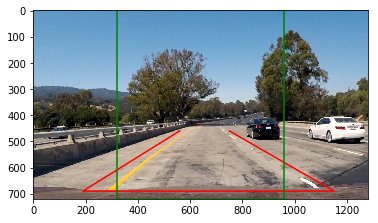

In [16]:
image_straight_lines = mpimg.imread(images[3])
roi_src = np.array([[560,460], [190,690], [1150,690], [750,460]], dtype='float32')
roi_dst = np.array([[320, 0], [320,720], [960,720], [960, 0]], dtype='float32')
plt.plot(roi_src[:,0], roi_src[:,1], 'r-')
plt.plot(roi_dst[:,0], roi_dst[:,1], 'g-')
plt.imshow(image_straight_lines)

In [17]:
def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    `vertices` should be a numpy array of integer points.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, np.array([vertices], dtype=np.int32), ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

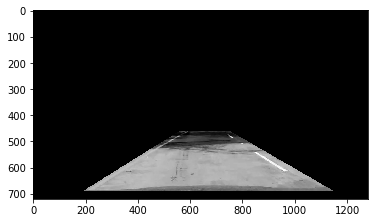

In [18]:
mask = region_of_interest(cv2.cvtColor(img, cv2.COLOR_RGB2GRAY), roi_src)
plt.imshow(mask, cmap='gray')

In [19]:
def corners_unwarp(img, src, dst):
    img_size = (img.shape[1], img.shape[0])
    # Given src and dst points, calculate the perspective transform matrix
    M = cv2.getPerspectiveTransform(src, dst)
    # Warp the image using OpenCV warpPerspective()
    warped = cv2.warpPerspective(img, M, img_size)

    return warped, M

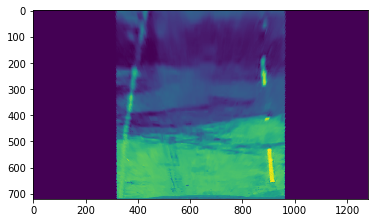

In [20]:
warped, M = corners_unwarp(mask, roi_src, roi_dst)
plt.imshow(warped)

### Image preprocessing function

In [28]:
settings = {
    'camera_mtx': camera_matrix,
    'dist_coeff': distortion_coff,
    'r_thresh': (150, 255),
    's_thresh': (100, 255),
    'grad_x': {
        'kernel': 9,
        'thresh': (10, 100)
    },
    'grad_y': {
        'kernel': 3,
        'thresh': (10, 100)
    },
    'grad_mag': {
        'kernel': 5,
        'thresh': (10, 100)
    },
    'grad_dir': {
        'kernel': 17,
        'thresh': (0.7, 1.3)
    },
    'warp': {
        'src': np.array([[560,460], [190,690], [1150,690], [750,460]], dtype='float32'),
        'dst': np.array([[320, 0], [320,720], [960,720], [960, 0]], dtype='float32')
    }
}

def threshold(img, thresh):
    assert len(img.shape) == 2
    mask = np.zeros_like(img)
    mask[(img >= thresh[0]) & (img <= thresh[1])] = 1
    return mask

def image_preprocessing(img, settings, display=False, save_path=''):
    # undistort
    undist = cv2.undistort(img, settings['camera_mtx'], settings['dist_coeff'], None, settings['camera_mtx'])
    
    # get red and sat channels
    hls = cv2.cvtColor(undist, cv2.COLOR_RGB2HLS)
    r_channel = undist[:,:,0]
    s_channel = hls[:,:,2]
    
    # color thresholding mask
    red_mask = threshold(r_channel, settings['r_thresh'])
    sat_mask = threshold(s_channel, settings['s_thresh'])
    color_mask = np.zeros_like(sat_mask)
    color_mask[((sat_mask == 1) & (red_mask == 1))] = 1
    
    # gradient thresholding
    grad_x = abs_sobel_thresh(s_channel, 'x', sobel_kernel=settings['grad_x']['kernel'], 
                              thresh=settings['grad_x']['thresh'])
    grad_y = abs_sobel_thresh(s_channel, 'y', sobel_kernel=settings['grad_y']['kernel'],
                              thresh=settings['grad_y']['thresh'])
    grad_mag = mag_thresh(s_channel, sobel_kernel=settings['grad_mag']['kernel'], 
                          thresh=settings['grad_mag']['thresh'])
    grad_dir = dir_thresh(s_channel, sobel_kernel=settings['grad_dir']['kernel'], 
                          thresh=settings['grad_dir']['thresh'])
    grad_mask = np.zeros_like(grad_dir)
    grad_mask[((grad_x == 1) & (grad_y == 1)) | ((grad_mag == 1) & (grad_dir == 1))] = 1
    
    # combined thresholds
    mask = np.zeros_like(grad_mask)
    mask[(grad_mask == 1) | (color_mask == 1)] = 1
    
    # roi 
    mask_roi = region_of_interest(img=mask, vertices=settings['warp']['src'])
    
    # warp
    warped, M = corners_unwarp(mask, settings['warp']['src'], settings['warp']['dst'])
    
    # display pipeline
    if display:
        plt.figure(figsize=(20,12))
        plt.subplot(331)
        plt.title('Original Image')
        plt.imshow(img)
        plt.subplot(332)
        plt.title('Undistort')
        plt.imshow(undist)
        plt.subplot(333)
        plt.title('Color Mask')
        plt.imshow(color_mask)
        plt.subplot(334)
        plt.title('Gradient Mask')
        plt.imshow(grad_mask)
        plt.subplot(335)
        plt.title('Combined Mask with ROI')
        plt.imshow(mask_roi)
        plt.subplot(336)
        plt.title('Birds eye view')
        plt.imshow(warped)
        if save_path:
            plt.savefig(save_path)
        plt.show()
    
    return warped
    

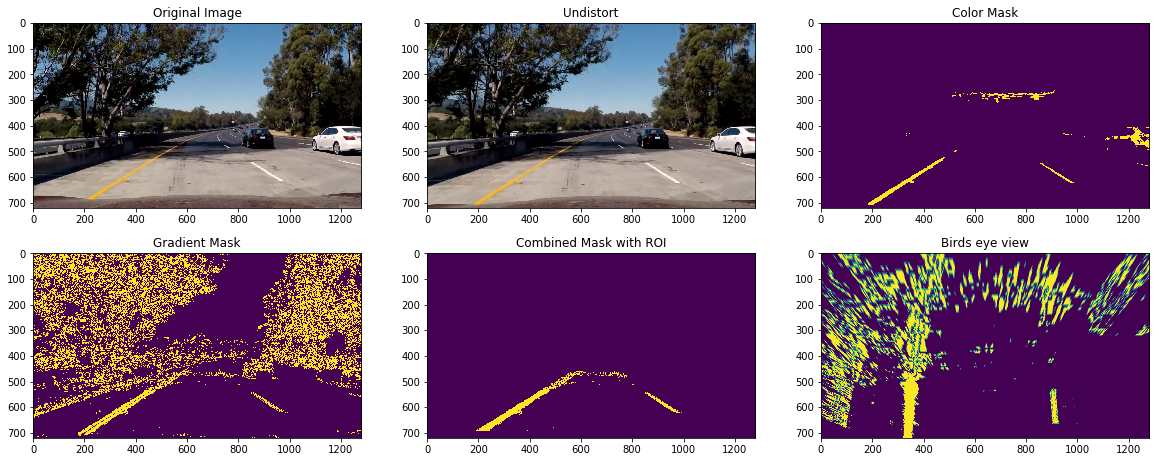

In [51]:
img = mpimg.imread(images[1])
output_mask = image_preprocessing(img, settings, display=True)

### Lane detection 

In [60]:
search_params = {
    'nwindows': 9, # Choose the number of sliding windows
    'margin': 100, # Set the width of the windows +/- margin
    'minpix': 50   # Set minimum number of pixels found to recenter window
}

def find_lane_pixels(img, params):    
    # Create histogram of image binary activations
    histogram = np.sum(img[img.shape[0]//2:,:], axis=0)
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    lane_gap = rightx_base-leftx_base
    
    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(img.shape[0]//params['nwindows'])
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
    
    # Step through the windows one by one
    for window in range(params['nwindows']):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = img.shape[0] - (window+1)*window_height
        win_y_high = img.shape[0] - window*window_height
        # Find the four below boundaries of the window
        win_xleft_low = leftx_current-params['margin']
        win_xleft_high = leftx_current+params['margin']
        win_xright_low = rightx_current-params['margin']
        win_xright_high = rightx_current+params['margin']
        
        #Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
                          (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
                          (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)

        # If you found > minpix pixels, recenter next window
        # (`right` or `leftx_current`) on their mean position
        if len(good_left_inds) > params['minpix']:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > params['minpix']:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
            
    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    return leftx, lefty, rightx, righty, lane_gap

_,_,_,_,lane_gap = find_lane_pixels(output_mask, search_params)
print(lane_gap)

555


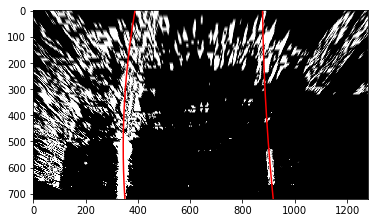

In [61]:
def fit_polynomial(img, params):
    # Find our lane pixels first
    leftx, lefty, rightx, righty, lane_gap = find_lane_pixels(img, params)

    # Fit a second order polynomial to each using `np.polyfit`
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    return left_fit, right_fit

def plot_ploy_lines(img, left_fit, right_fit):
    # Generate x and y values for plotting
    ploty = np.linspace(0, img.shape[0]-1, img.shape[0] )
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty

    plt.imshow(img, cmap='gray')
    plt.plot(left_fitx, ploty, color='red')
    plt.plot(right_fitx, ploty, color='red')
    
left_fit, right_fit = fit_polynomial(output_mask, search_params)
plot_ploy_lines(output_mask, left_fit, right_fit)

### Get curvature

In [67]:
def measure_curvature(y, left_fit, right_fit):
    '''
    Calculates the curvature of polynomial functions.
    '''
        
    # calculation of R_curve (radius of curvature)
    left_curverad = ((1 + (2*y*left_fit[0]+left_fit[1])**2)**(3/2))/np.absolute(2*left_fit[0])
    right_curverad = ((1 + (2*y*right_fit[0]+right_fit[1])**2)**(3/2))/np.absolute(2*right_fit[0])
    
    return left_curverad, right_curverad

measure_curvature(719, left_fit, right_fit)

(3061.9173208288794, 8333.75065873857)

In [68]:
# meters per pixels
xm = 3.7/lane_gap
ym = 30/720

def cvt_line_meters(line):
    new_line = np.copy(line)
    new_line[0] *= xm/(ym**2)
    new_line[1] *= xm/ym
    return new_line

left_fit_m = cvt_line_meters(left_fit)
right_fit_m = cvt_line_meters(right_fit)

measure_curvature(719*ym, left_fit_m, right_fit_m)

(792.5865135274738, 2138.6969115382476)